# Working with vector valued variables for multiple groups in PyMC

This notebook is written as a response to a recurring question on GitHub and Discourse:  
*“How do I handle multiple groups of data in PyMC and slice vector random variables correctly?”*

The user’s example had several groups of observations and a vector of `mu` and `sigma` values, one for each group.  
The confusing part was how to turn the group labels into something PyMC can index cleanly, and how to connect those indices to vector valued priors.

To make the idea clear, I built a very small example with two levels:

- a category (like Beverage or Snack)
- a family inside each category

The goal here isn’t to create a big statistical model,
it’s just to show the exact pattern for:
- factorizing group labels  
- building the mapping between levels  
- creating vector RVs  
- and slicing them correctly inside the likelihood  

Once you see this simple version working, the structure becomes easy to reuse in real models.



## 1. Setup

Before jumping into the modeling part, we just import the usual tools: NumPy, pandas, ArviZ, and PyMC.  
I also set a random seed so the results don’t wiggle around every time this notebook runs.

One small thing I like doing , and it helps a lot later is defining named coordinates for the different group levels we’ll work with.  
These labels make ArviZ’s output much easier to read because the plots will show actual names instead of axis numbers.



In [10]:
# Importing the basic libraries we need
# Nothing special here, just the usual stack for PyMC work
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pymc as pm

rng = np.random.default_rng(42)
az.style.use("arviz-darkgrid")

print("PyMC version:", pm.__version__)

PyMC version: 5.26.1


## 2. A small dataset to illustrate the idea

The original GitHub issue used five groups of synthetic data.  
To keep things intuitive here, I’m using a slightly more “real world sounding” example: categories and families.

The dataset has three columns:

- `category`  
- `family` (which lives inside a category)  
- `sales` (just some numeric values we’ll fit a model to)

The exact numbers don’t matter what matters is that each row belongs to one family, and each family belongs to one category.  
That structure is exactly the situation the user in the issue was dealing with.


In [2]:
# Tiny example dataset
data = pd.DataFrame(
    {
        "category": ["Beverage", "Beverage", "Beverage", "Snack", "Snack"],
        "family": ["Tea", "Milk", "Soft Drinks", "Chips", "Nuts"],
    }
)

# Pretend we observed some sales numbers (generated from a simple ground truth)
true_sales = {
    "Tea": 15.0,
    "Milk": 10.0,
    "Soft Drinks": 20.0,
    "Chips": 7.0,
    "Nuts": 5.0,
}
data["sales"] = [true_sales[f] + rng.normal(0, 2.0) for f in data["family"]]

data

,category,family,sales
0,Beverage,Tea,15.609434
1,Beverage,Milk,7.920032
2,Beverage,Soft Drinks,21.500902
3,Snack,Chips,8.881129
4,Snack,Nuts,1.097930


## 3. Turning text labels into indices and making the mapping

The thing that usually trips people up is how to connect the observed labels to vector-valued priors.

PyMC can only index arrays with integers, so the first step is simply:
- convert the category names into integer codes
- convert the family names into integer codes

Once we have those, we make a small array that maps each family to its category.  
For example: if the 0th family belongs to the 1st category, the mapping array contains a 1 at position 0.

This mapping array is the heart of the whole trick.  
It tells PyMC how the lower level “inherits” from the upper level.



In [ ]:
# Factorize categories and families into integer codes
cat_codes, cat_labels = pd.factorize(data["category"])
fam_codes, fam_labels = pd.factorize(data["family"])

data["cat_code"] = cat_codes
data["fam_code"] = fam_codes

print("Category labels:", list(cat_labels))
print("Family labels:", list(fam_labels))
display(data)

# Build mapping
edges = data[["fam_code", "cat_code"]].drop_duplicates().sort_values("fam_code")

family_to_category = edges["cat_code"].to_numpy().astype("int64")

print("\nfamily_to_category mapping (family index → category index):", family_to_category)
print("Length (should equal number of families):", len(family_to_category), "vs", len(fam_labels))

Category labels: ['Beverage', 'Snack']
Family labels: ['Tea', 'Milk', 'Soft Drinks', 'Chips', 'Nuts']


,category,family,sales,cat_code,fam_code
0,Beverage,Tea,15.609434,0,0
1,Beverage,Milk,7.920032,0,1
2,Beverage,Soft Drinks,21.500902,0,2
3,Snack,Chips,8.881129,1,3
4,Snack,Nuts,1.097930,1,4



family_to_category mapping (family index → category index): [0 0 0 1 1]
Length (should equal number of families): 5 vs 5


## 4. Building the PyMC model

Now that the indices and mapping are ready, the model becomes fairly straightforward.

We set up:
- one global intercept
- one category effect per category
- one family effect per family

The important part is that the family effect is centered on the category effect using the mapping array we created earlier.  
That’s exactly the pattern the user in the GitHub issue needed but wasn’t sure how to set up.

For each observation, the expected value is:

global_mu  
+ the effect for its category  
+ the effect for its family

Once the indexing is correct, PyMC takes it from there.



In [11]:
coords = {
    "category": cat_labels,
    "family": fam_labels,
    "obs": np.arange(len(data)),
}

with pm.Model(coords=coords) as model:
    # Global mean
    global_mu = pm.Normal("global_mu", mu=10.0, sigma=10.0)

    # Level 0: category level vector variable
    sigma_cat = pm.HalfNormal("sigma_cat", sigma=5.0)
    category_effect = pm.Normal(
        "category_effect",
        mu=global_mu,
        sigma=sigma_cat,
        dims="category",
    )

    # Level 1: family level vector variable, centered on its category
    sigma_fam = pm.HalfNormal("sigma_fam", sigma=3.0)
    family_effect = pm.Normal(
        "family_effect",
        mu=category_effect[family_to_category],
        sigma=sigma_fam,
        dims="family",
    )

    # Observation model: each row uses its family's effect
    sigma_obs = pm.HalfNormal("sigma_obs", sigma=2.0)
    mu = family_effect[fam_codes]

    sales = pm.Normal(
        "sales",
        mu=mu,
        sigma=sigma_obs,
        observed=data["sales"].values,
        dims="obs",
    )

model

      global_mu ~ Normal(10, 10)
      sigma_cat ~ HalfNormal(0, 5)
category_effect ~ Normal(global_mu, sigma_cat)
      sigma_fam ~ HalfNormal(0, 3)
  family_effect ~ Normal(f(category_effect), sigma_fam)
      sigma_obs ~ HalfNormal(0, 2)
          sales ~ Normal(f(family_effect), sigma_obs)

## 5. Sampling

Here we let PyMC run `pm.sample()` to draw posterior samples.  
Because the dataset is tiny, this finishes quickly.

In real modeling work, I’d look at the diagnostics (R-hat, effective sample size, divergences).  
But since this notebook is mainly about *how* to wire up the hierarchical structure, I’m keeping this part simple.


In [16]:
%%capture sampling_output

with model:
    idata = pm.sample(
        draws=1000,
        tune=1000,
        target_accept=0.95,
        chains=4,
        random_seed=42,
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_mu, sigma_cat, category_effect, sigma_fam, family_effect, sigma_obs]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
print("Sampling finished")

az.summary(idata, var_names=["global_mu", "category_effect", "family_effect"])

Sampling finished


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
global_mu,10.388,3.948,2.743,17.829,0.128,0.116,957.0,1060.0,1.00
category_effect[Beverage],13.100,3.043,7.167,18.509,0.114,0.087,708.0,992.0,1.00
category_effect[Snack],7.666,3.451,1.303,14.143,0.140,0.086,607.0,967.0,1.00
family_effect[Tea],14.867,2.355,9.928,19.003,0.100,0.112,680.0,444.0,1.01
family_effect[Milk],9.568,2.792,5.356,15.709,0.122,0.086,594.0,1149.0,1.00
family_effect[Soft Drinks],18.811,3.406,12.028,23.687,0.210,0.140,307.0,561.0,1.00
family_effect[Chips],8.474,2.405,3.576,13.231,0.086,0.103,834.0,797.0,1.00
family_effect[Nuts],3.094,3.050,-1.599,9.550,0.157,0.117,442.0,652.0,1.00


## 6. Inspecting the results

Now we look at the fitted parameters.  
You should see something like:

- category effects (one per category)
- family effects (one per family), roughly centered on their category’s effect

Thanks to the named dimensions we defined earlier, ArviZ will label everything clearly in the plots.  
That was one of the frustrations mentioned in the GitHub issue things got confusing fast without readable labels.


In [6]:
az.summary(idata, var_names=["category_effect", "family_effect"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
category_effect[Beverage],13.233,3.067,7.351,18.924,0.117,0.101,688.0,830.0,1.0
category_effect[Snack],7.731,3.501,1.323,14.254,0.137,0.086,648.0,718.0,1.0
family_effect[Tea],14.814,2.436,9.550,18.912,0.093,0.112,609.0,909.0,1.0
family_effect[Milk],9.731,2.897,4.775,15.363,0.168,0.152,363.0,477.0,1.0
family_effect[Soft Drinks],18.828,3.397,12.115,23.949,0.234,0.128,254.0,681.0,1.0
family_effect[Chips],8.505,2.368,3.783,12.998,0.090,0.107,746.0,600.0,1.0
family_effect[Nuts],3.243,3.056,-1.170,10.038,0.201,0.147,309.0,437.0,1.0


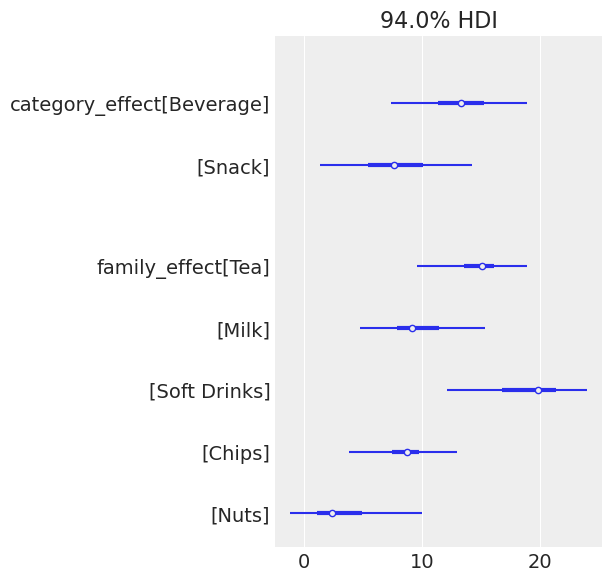

In [7]:
az.plot_forest(
    idata,
    var_names=["category_effect", "family_effect"],
    combined=True,
)
plt.show()

## 7. Takeaways

Once you walk through this pattern once, it becomes much easier to set up similar models:

- factorize the labels into integer indices  
- build one mapping array from the lower level to the upper level  
- index the upper level parameters using that mapping  
- use those indexed values to center the lower level parameters

This is all the original GitHub post was struggling with on how to slice vector RVs cleanly.

Once the mapping is in place, the rest of the model looks like any other hierarchical setup.


## Optional: Extending this pattern to more than two levels

This example uses two levels (category and family), but the same idea works for any number of levels.  
The key ingredients stay the same:

1. factorize each level of labels into integer codes  
2. build a mapping array from each level to the one above it  
3. use that mapping to index the parent vector inside the next level’s prior

For example, if you had three levels:

- level_0
- level_1
- level_2

You would create the following:

- level_1_to_level_0
- level_2_to_level_1

Then you would define priors like this:

- level_0_effect
- level_1_effect, centered on level_0_effect[level_1_to_level_0]
- level_2_effect, centered on level_1_effect[level_2_to_level_1]

Each additional level only requires one more factorized index and one more mapping array.  
Nothing else about the PyMC model needs to change.

This is what people sometimes call a telescoping hierarchy: every group is centered on the group above it, and the indexing arrays connect the levels together.


## Watermark

In [8]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 25 2025

Python implementation: CPython
Python version       : 3.11.14
IPython version      : 9.7.0

matplotlib: 3.10.7
pymc      : 5.26.1+28.g4ad7fa8f8
arviz     : 0.22.0
pandas    : 2.3.3
numpy     : 2.3.5

Watermark: 2.5.0

